In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import sqlite3
import json
import statsmodels.api as sm
from lmfit.model import Model, save_modelresult, load_modelresult
from lmfit.models import LinearModel
from lmfit import minimize, Parameters, create_params
import scipy.constants as sc
import matplotlib as mpl
import statsmodels.formula.api as smf

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

In [2]:
def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

In [4]:
# Load data

global_fits = '../06_aggfit_ntp_adduction/reference/EKC.01.061.analyze_fit_distributions/global_refit_results_withCs.db'

conn = sqlite3.connect(global_fits)
query = 'SELECT * FROM global_fits'
fits = pd.read_sql_query(query, conn)

# get experimental info
main_db  = '../06_aggfit_ntp_adduction/reference/EKC.01.060.developing_DB_input/new.db'
conn = sqlite3.connect(main_db)
query = """
    SELECT pr.temperature, c.disp_name, rg.rg_id, pr.buffer_id
    FROM reaction_groups rg
    JOIN constructs c ON pr.construct_id = c.id
    LEFT JOIN probing_reactions pr ON rg.rxn_id = pr.id
    WHERE pr.RT = 'MRT'
    GROUP BY rg.rg_id
"""
exp_info = pd.read_sql_query(query, conn)
fits['rg_id'] = fits['rg_id'].astype(int)
fits = fits.merge(exp_info, left_on='rg_id', right_on='rg_id', how='left')

# drop duplicates
fits = fits.drop_duplicates()
# filter fits to under 85C
fits = fits[fits['temperature'] < 85]
fits

,site,log_kappa,log_kdeg,log_fmod_0,r2,stderr_log_kappa,stderr_log_kdeg,stderr_log_fmod_0,rg_id,temperature,disp_name,buffer_id
0,1,-6.816452,-8.121080,-11.629118,0.953716,0.110213,0.0,9.961597,7,25,4U_a8c,1
1,2,-5.267578,-8.121080,-6.841065,0.917437,0.150436,0.0,0.531036,7,25,4U_a8c,1
2,3,-4.680462,-8.121080,-5.801307,0.938039,0.129168,0.0,0.288928,7,25,4U_a8c,1
3,5,-7.617252,-8.121080,-7.020689,0.684740,0.339345,0.0,0.137336,7,25,4U_a8c,1
4,6,-6.082823,-8.121080,-6.875103,0.920598,0.147028,0.0,0.238243,7,25,4U_a8c,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7272,9,-3.537457,-6.744415,-5.132881,0.992724,0.038891,0.0,0.149966,82,37,4U_wt,1
7273,25,-3.217183,-6.702464,-6.482345,0.999231,0.005345,0.0,0.077530,3,37,4U_wt,1
7274,25,-3.438874,-6.741250,-6.396819,0.996077,0.028552,0.0,0.416546,22,37,4U_wt,1
7275,25,-4.017535,-6.702023,-6.516996,0.991103,0.042777,0.0,0.413968,81,37,4U_wt,1


In [5]:
# Load data (4U_filt)

global_fits_4Ufilt = '../06_aggfit_ntp_adduction/reference/EKC.01.054.06_stringent_fourU_analysis/global_refit_results_4Ufilt.db'

conn = sqlite3.connect(global_fits_4Ufilt)
query = 'SELECT * FROM global_fits'
fits_4Ufilt = pd.read_sql_query(query, conn)


# get experimental info
main_db  = '../06_aggfit_ntp_adduction/reference/EKC.01.054.06_stringent_fourU_analysis/4Ufilt_main.db'
conn = sqlite3.connect(main_db)
query = """
    SELECT pr.temperature, c.disp_name, rg.rg_id, pr.buffer_id
    FROM reaction_groups rg
    JOIN constructs c ON pr.construct_id = c.id
    LEFT JOIN probing_reactions pr ON rg.rxn_id = pr.id
    WHERE pr.RT = 'MRT'
    GROUP BY rg.rg_id
"""
exp_info = pd.read_sql_query(query, conn)
fits_4Ufilt['rg_id'] = fits_4Ufilt['rg_id'].astype(int)
fits_4Ufilt = fits_4Ufilt.merge(exp_info, left_on='rg_id', right_on='rg_id', how='left')

# drop duplicates
fits_4Ufilt = fits_4Ufilt.drop_duplicates()
# filter fits_4Ufilt to under 85C
fits_4Ufilt = fits_4Ufilt[fits_4Ufilt['temperature'] < 85]
fits_4Ufilt['disp_name'] = 'pH8_2xWT'

In [6]:
fits = pd.concat([fits, fits_4Ufilt], ignore_index=True)

In [7]:
# degradation rate from NMR

temps = []
reps = []
kdeg_vals = []

for temp in [25, 30, 37, 45, 52, 60]:
    for rep in ['a', 'b']:
        if temp == 30 and rep =='b':
            continue
        # read json-like file /home/ekc5108/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.058.XSB_training_DMS/nmr_dms_deg/52_a.sav
        with open(f'../data/nmr_dms_deg/{temp}_{rep}.sav') as f:
            data = json.load(f)
        kdeg_val = 1 / data['params'][1][1]
        temps.append(temp)
        reps.append(rep)
        kdeg_vals.append(kdeg_val)

df_kdeg = pd.DataFrame({'temperature': temps, 'replicate': reps, 'kdeg': kdeg_vals})
df_kdeg['log_kdeg'] = np.log(df_kdeg['kdeg'])
df_kdeg['inv_temp'] = 1 / (df_kdeg['temperature'] + 273.15)
df_kdeg['disp_name'] = 'nmr'
df_kdeg = df_kdeg[['log_kdeg', 'temperature', 'disp_name', 'inv_temp']]
# # linear fit to get curve
# model = lmfit.models.LinearModel()
# params = model.make_params()
# deg_result = model.fit(df_kdeg['lnkdeg'], params, x=df_kdeg['inv_temp'])

In [8]:
def eval_extrapolate(x, slope, slope_err, intercept, intercept_err, cov_mb=0.0):
    """
    Evaluate a linear function y = mx + b at a given x with propagated uncertainty.
    
    Parameters:
    x (float): The x-value at which to evaluate the function.
    slope (float): The slope (m) of the linear function.
    slope_err (float): The uncertainty in the slope.
    intercept (float): The intercept (b) of the linear function.
    intercept_err (float): The uncertainty in the intercept.
    cov_mb (float): The covariance between slope and intercept. Default is 0 (assumes they are uncorrelated).
    
    Returns:
    tuple: (y, uncertainty_y), where y is the evaluated value and uncertainty_y is the propagated uncertainty.
    """
    y = slope * x + intercept
    variance_y = (x * slope_err) ** 2 + intercept_err ** 2 + 2 * x * cov_mb
    uncertainty_y = np.sqrt(variance_y)
    return y, uncertainty_y

### ln(kobs) distribution by base

In [9]:
def violinplot_lnkobs_dist(fits, temps, sites, disp_name, base):
    select_fits = fits.copy()

    # filt name contains "4U_wt" or "4U_a8c"
    select_fits = select_fits[select_fits['disp_name'].str.contains(disp_name)]
    # filter temps 25, 30, 37, 45, 52, 60, 75
    select_fits = select_fits[select_fits['temperature'].isin(temps)]
    select_fits.loc[:, 'inv_temp'] = 1/(273.15 + select_fits['temperature'])
    select_fits.loc[:, 'log_kobs'] = select_fits['log_kappa'] + select_fits['log_kdeg']

    select_fits_A = select_fits[select_fits['site'].isin(sites)]

    # get average at each 'inv_temp' and 'site'
    avg_kobs_A = select_fits_A.groupby(['inv_temp', 'temperature', 'site', 'disp_name'])['log_kobs'].mean().reset_index()

    if len(temps) < 5:
        draw_points = 'points'
    else:
        draw_points = None

    fig, ax = plt.subplots(figsize=(3, 3))
    sns.violinplot(x='temperature', y='log_kobs', data=avg_kobs_A, inner = draw_points, color = 'gray', ax = ax)
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel(r'$\ln(k_{obs})$')
    plt.tight_layout()
    # move legend outside of plot
    #plt.savefig(f'{disp_name}_avg_kobs_violin_{base}s.pdf')
    plt.show()

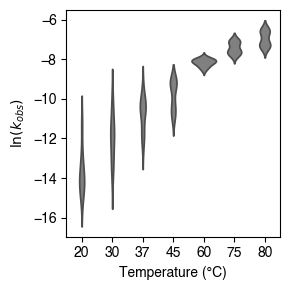

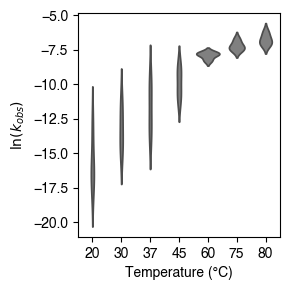

In [10]:
sites_dict_4U = {'A': [7, 15, 16, 18, 22, 26, 29, 34, 35], 'C': [9, 25]}
temps = [20, 30, 37, 45, 60, 75, 80]
violinplot_lnkobs_dist(fits, temps, sites_dict_4U['A'], '4U_', 'A')
violinplot_lnkobs_dist(fits, temps, sites_dict_4U['C'], '4U_', 'C')

### Aggregated fits of melted $k_{obs}$ for fourU thermometer

In [11]:
def aggregated_linfit_melted(fits, sites, disp_name, base, plot = True, extrapolate = None):
    all_melted = fits.copy()#[fits['temperature'] > 59]
    # filt name contains "4U_wt" or "4U_a8c"
    all_melted = all_melted[all_melted['disp_name'].str.contains(disp_name)]
    all_melted = all_melted[all_melted['temperature'] > 59]
    all_melted.loc[:, 'inv_temp'] = 1/(273.15 + all_melted['temperature'])
    all_melted.loc[:, 'log_kobs'] = all_melted['log_kappa'] + all_melted['log_kdeg']

    if disp_name == 'hiv_':
        all_melted = all_melted[all_melted['log_kobs'] > -9.5]


    # filter sites 7, 8, 9, 15, 16, 18, 22, 25, 26, 29, 34, 35
    select_melted = all_melted[all_melted['site'].isin(sites)]

    # Compute mean and standard deviation of log_kobs at each inv_temp for weighting
    grouped = select_melted.groupby(['disp_name', 'inv_temp'])['log_kobs'].agg(['mean', 'std']).reset_index()
    grouped['weight'] = 1 / (grouped['std'] ** 2)  # Inverse variance weighting

    # Function to perform weighted linear regression
    def weighted_linear_regression(data):
        X = data['inv_temp'].values
        y = data['mean'].values
        weights = data['weight'].fillna(data['weight'].median()).values  # Handle NaNs in weights

        X = sm.add_constant(X)  # Add intercept
        model = sm.WLS(y, X, weights=weights).fit()

        return model.params, model.bse, model

    # Perform regression for each disp_name
    results = {}
    models = {}

    for disp_name, group in grouped.groupby('disp_name'):
        params, errors, model = weighted_linear_regression(group)
        models[disp_name] = model  # Store model for plotting
        results[disp_name] = {
            'intercept': params[0],
            'slope': params[1],
            'intercept_se': errors[0],
            'slope_se': errors[1]
        }

    # Perform regression for the aggregated dataset
    params, errors, model = weighted_linear_regression(grouped)
    models['aggregated'] = model
    results['aggregated'] = {
        'intercept': params[0],
        'slope': params[1],
        'intercept_se': errors[0],
        'slope_se': errors[1]
    }

    # Convert results to a DataFrame
    results_df = pd.DataFrame.from_dict(results, orient='index')

    results_df['base'] = base

    if plot:
        # Plot regression results
        fig, ax = plt.subplots(figsize=(3, 3))
        color_dict = {'4U_wt': 'darkgray', '4U_a8c': 'darkred',
                        'hiv_a35g': '#55a868', 'hiv_c30u': '#c54f53', 'hiv_wt': '#4d73b1', 'hiv_gs': '#de8452', 'hiv_es2': '#8173b5'}

        if extrapolate != None:
            alpha_construct = 0.2
        else:
            alpha_construct = 1

        for disp_name, group in grouped.groupby('disp_name'):
            ax.scatter(group['inv_temp'], group['mean'], s = 15, color = color_dict[disp_name], alpha = alpha_construct)
            X_fit = np.linspace(group['inv_temp'].min(), group['inv_temp'].max(), 100)

            if extrapolate != None:
                extrap_temp = 1 / (extrapolate + 273.15)

                # append to X_fit
                X_fit = np.append(X_fit, extrap_temp)
                
            Y_fit = models[disp_name].params[0] + models[disp_name].params[1] * X_fit
            label = disp_name.split('_')[1].upper()
            ax.plot(X_fit, Y_fit, label=f"{label}", linestyle="--", linewidth = 1, color = color_dict[disp_name], alpha = alpha_construct)

        X_fit = np.linspace(grouped['inv_temp'].min(), grouped['inv_temp'].max(), 100)
        if extrapolate != None:
            extrap_temp = 1 / (extrapolate + 273.15)

            # append to X_fit
            X_fit = np.append(X_fit, extrap_temp)
        Y_fit = models['aggregated'].params[0] + models['aggregated'].params[1] * X_fit

        aggfit_color = 'black'

        if extrapolate != None:
            if base == 'A':
                aggfit_color = sns.color_palette("Paired")[1]
            elif base == 'C':
                aggfit_color = sns.color_palette("Paired")[5]
            elif base == 'G':
                aggfit_color = sns.color_palette("Paired")[3]

        ax.plot(X_fit, Y_fit, label="Agg. Fit", linestyle="-", color=aggfit_color)
        # formatter
        formatter = FuncFormatter(thousands)
        ax.xaxis.set_major_formatter(formatter)
        ax.set_ylabel(r'$\ln(k_{obs})$')
        ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
        plt.legend(frameon=False, loc='upper right')
        plt.tight_layout()
        #plt.title("Weighted Linear Fit at Melted Temps.")
        #plt.savefig()
        plt.savefig(f'agg_fit_{disp_name}_melt_{base}s{extrapolate}.pdf')
        plt.show()

    return results_df


### AX PLOTTING VERSION
def aggregated_linfit_melted_ax(fits, sites, disp_name, base, ax, plot = True, extrapolate = None):
    all_melted = fits.copy()#[fits['temperature'] > 59]
    # filt name contains "4U_wt" or "4U_a8c"
    all_melted = all_melted[all_melted['disp_name'].str.contains(disp_name)]
    all_melted = all_melted[all_melted['temperature'] > 59]
    all_melted.loc[:, 'inv_temp'] = 1/(273.15 + all_melted['temperature'])
    all_melted.loc[:, 'log_kobs'] = all_melted['log_kappa'] + all_melted['log_kdeg']

    if disp_name == 'hiv_':
        all_melted = all_melted[all_melted['log_kobs'] > -9.5]


    # filter sites 7, 8, 9, 15, 16, 18, 22, 25, 26, 29, 34, 35
    select_melted = all_melted[all_melted['site'].isin(sites)]

    # Compute mean and standard deviation of log_kobs at each inv_temp for weighting
    grouped = select_melted.groupby(['disp_name', 'inv_temp'])['log_kobs'].agg(['mean', 'std']).reset_index()
    grouped['weight'] = 1 / (grouped['std'] ** 2)  # Inverse variance weighting

    # Function to perform weighted linear regression
    def weighted_linear_regression(data):
        X = data['inv_temp'].values
        y = data['mean'].values
        weights = data['weight'].fillna(data['weight'].median()).values  # Handle NaNs in weights

        X = sm.add_constant(X)  # Add intercept
        model = sm.WLS(y, X, weights=weights).fit()

        return model.params, model.bse, model

    # Perform regression for each disp_name
    results = {}
    models = {}

    for disp_name, group in grouped.groupby('disp_name'):
        params, errors, model = weighted_linear_regression(group)
        models[disp_name] = model  # Store model for plotting
        results[disp_name] = {
            'intercept': params[0],
            'slope': params[1],
            'intercept_se': errors[0],
            'slope_se': errors[1]
        }

    # Perform regression for the aggregated dataset
    params, errors, model = weighted_linear_regression(grouped)
    models['aggregated'] = model
    results['aggregated'] = {
        'intercept': params[0],
        'slope': params[1],
        'intercept_se': errors[0],
        'slope_se': errors[1]
    }

    # Convert results to a DataFrame
    results_df = pd.DataFrame.from_dict(results, orient='index')

    results_df['base'] = base

    if plot:
        # Plot regression results
        color_dict = {'4U_wt': 'darkgray', '4U_a8c': 'darkred',
                        'hiv_a35g': '#55a868', 'hiv_c30u': '#c54f53', 'hiv_wt': '#4d73b1', 'hiv_gs': '#de8452', 'hiv_es2': '#8173b5'}

        if extrapolate != None:
            alpha_construct = 0.2
        else:
            alpha_construct = 1

        for disp_name, group in grouped.groupby('disp_name'):
            ax.scatter(group['inv_temp'], group['mean'], s = 15, color = color_dict[disp_name], alpha = alpha_construct)
            X_fit = np.linspace(group['inv_temp'].min(), group['inv_temp'].max(), 100)

            if extrapolate != None:
                extrap_temp = 1 / (extrapolate + 273.15)

                # append to X_fit
                X_fit = np.append(X_fit, extrap_temp)
                
            Y_fit = models[disp_name].params[0] + models[disp_name].params[1] * X_fit
            label = disp_name.split('_')[1].upper()
            ax.plot(X_fit, Y_fit, label=f"{label}", linestyle="--", linewidth = 1, color = color_dict[disp_name], alpha = alpha_construct)

        X_fit = np.linspace(grouped['inv_temp'].min(), grouped['inv_temp'].max(), 100)
        if extrapolate != None:
            extrap_temp = 1 / (extrapolate + 273.15)

            # append to X_fit
            X_fit = np.append(X_fit, extrap_temp)
        #X_fit = np.append(X_fit, extrap_temp)
        Y_fit = models['aggregated'].params[0] + models['aggregated'].params[1] * X_fit


        model = LinearModel()
        params = model.make_params()
        out = model.fit(select_melted['log_kobs'], params, x=select_melted['inv_temp'])

        # extrapolate to temp
        lnkadd_val = out.eval(x = extrap_temp)
        lnkadd_err = out.eval_uncertainty(x = extrap_temp)

        print(f"lnkadd_val: {lnkadd_val}, lnkadd_err: {lnkadd_err}")



        aggfit_color = 'black'

        if extrapolate != None:
            if base == 'A':
                aggfit_color = sns.color_palette("Paired")[1]
            elif base == 'C':
                aggfit_color = sns.color_palette("Paired")[5]
            elif base == 'G':
                aggfit_color = sns.color_palette("Paired")[3]

        ax.plot(X_fit, Y_fit, label="Agg. Fit", linestyle="-", color=aggfit_color)
    return ax

In [12]:
sites_dict = {'A': [7, 15, 16, 18, 22, 26, 29, 34, 35], 'C': [9, 25], 'G': [19, 31]}

#### A positions

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


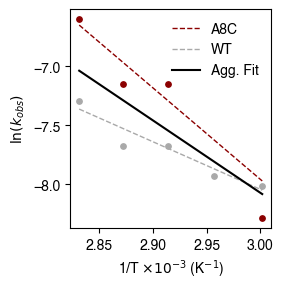

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


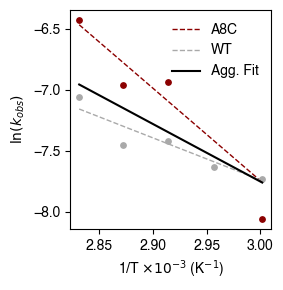

In [13]:
Asites_df = aggregated_linfit_melted(fits, sites_dict['A'], '4U_', 'A', plot = True)
Csites_df  = aggregated_linfit_melted(fits, sites_dict['C'], '4U_', 'C', plot = True)
ACsites_df = pd.concat([Asites_df, Csites_df])
ACsites_df.reset_index(inplace = True)
# calculate lnkadd at 20C for each of the regressions
ACsites_df['lnkadd_20C'] = ACsites_df.apply(lambda x: eval_extrapolate(1/(273.15 + 20), x['slope'], x['slope_se'], x['intercept'], x['intercept_se'])[0], axis=1)
ACsites_df['lnkadd_20C_err'] = ACsites_df.apply(lambda x: eval_extrapolate(1/(273.15 + 20), x['slope'], x['slope_se'], x['intercept'], x['intercept_se'])[1], axis=1)
#ACsites_df.to_csv('fourU_agg_kaddfits.csv', index = False)

In [14]:
ACsites_df

,index,intercept,slope,intercept_se,slope_se,base,lnkadd_20C,lnkadd_20C_err
0,4U_a8c,15.301103,-7753.210853,7.307395,2535.607889,A,-11.146828,11.323086
1,4U_wt,4.057575,-4033.404326,1.663782,565.175331,A,-9.701266,2.546589
2,aggregated,10.338101,-6136.742559,4.076775,1391.452244,A,-10.595696,6.256985
3,4U_a8c,15.029366,-7591.374133,7.518023,2605.939403,C,-10.866504,11.642286
4,4U_wt,2.619001,-3452.435293,1.503213,505.790955,C,-9.158025,2.288348
5,aggregated,6.421896,-4724.485767,2.807651,946.425818,C,-9.694378,4.278542


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


lnkadd_val: -11.05072407372096, lnkadd_err: 0.2530665150217529
lnkadd_val: -10.593639175112697, lnkadd_err: 0.5631619210442631
lnkadd_val: -13.055949727885936, lnkadd_err: 1.3949262699663838


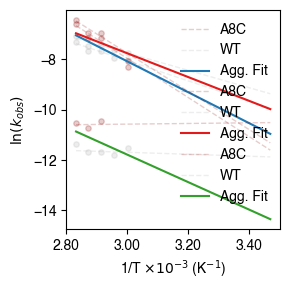

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
ax = aggregated_linfit_melted_ax(fits, sites_dict['A'], '4U_', 'A', ax, plot = True, extrapolate = 15)
ax = aggregated_linfit_melted_ax(fits, sites_dict['C'], '4U_', 'C', ax, plot = True, extrapolate = 15)
ax = aggregated_linfit_melted_ax(fits, sites_dict['G'], '4U_', 'G', ax, plot = True, extrapolate = 15)

# formatter
formatter = FuncFormatter(thousands)
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel(r'$\ln(k_{obs})$')
ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
plt.legend(frameon=False, loc='upper right')
plt.tight_layout()
#plt.title("Weighted Linear Fit at Melted Temps.")
#plt.savefig()
plt.savefig(f'agg_fit_4U_melt_ACGs_15.pdf')
plt.show()

### Distribution HIV

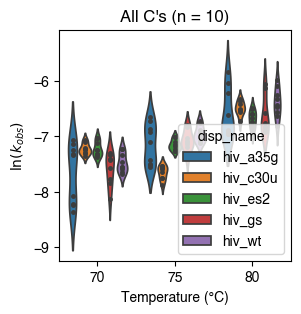

In [ ]:
all_melted = fits.copy()#[fits['temperature'] > 59]
# filt name contains "4U_wt" or "4U_a8c"
all_melted = all_melted[all_melted['disp_name'].str.contains('hiv_')]
#all_melted = all_melted[~all_melted['disp_name'].str.contains('C30U')]
# filter temps 25, 30, 37, 45, 52, 60, 75
all_melted = all_melted[all_melted['temperature'] > 25]
all_melted.loc[:, 'inv_temp'] = 1/(273.15 + all_melted['temperature'])
all_melted.loc[:, 'log_kobs'] = all_melted['log_kappa'] + all_melted['log_kdeg']
# exclude filter out values under -10
all_melted = all_melted[all_melted['log_kobs'] > -9.5]

# filter sites 7, 8, 9, 15, 16, 18, 22, 25, 26, 29, 34, 35
all_melted_C = all_melted[all_melted['site'].isin([19, 24, 29, 30, 37, 39, 41, 44, 45])]

# get average at each 'inv_temp' and 'site'
avg_kobs_C = all_melted_C.groupby(['inv_temp', 'temperature', 'site', 'disp_name'])['log_kobs'].mean().reset_index()

avg_kobs_C['base'] = 'C'

fig, ax = plt.subplots(figsize=(3, 3))
sns.violinplot(x='temperature', y='log_kobs', data=avg_kobs_C, inner = 'points', hue = 'disp_name', ax = ax)
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel(r'$\ln(k_{obs})$')
ax.set_title('All C\'s (n = 10)')
# move legend outside of plot
#plt.savefig('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/avg_kobs_violin_As.pdf')
plt.show()

In [ ]:
def process_select_lnkobs(fits, temps, sites, disp_name, base, ax = ax):
    select_fits = fits.copy()

    # filt name contains "4U_wt" or "4U_a8c"
    select_fits = select_fits[select_fits['disp_name'].str.contains(disp_name)]
    # filter temps 25, 30, 37, 45, 52, 60, 75
    select_fits = select_fits[select_fits['temperature'].isin(temps)]
    select_fits.loc[:, 'inv_temp'] = 1/(273.15 + select_fits['temperature'])
    select_fits.loc[:, 'log_kobs'] = select_fits['log_kappa'] + select_fits['log_kdeg']

    select_fits_A = select_fits[select_fits['site'].isin(sites)]

    # exclude site 35 and disp_name == 'hiv_a35g'
    select_fits_A = select_fits_A[~((select_fits['site'] == 35) & (select_fits['disp_name'] == 'hiv_a35g'))]

    # exclude site 30 disp_name == 'hiv_c30u'
    select_fits_A = select_fits_A[~((select_fits['site'] == 30) & (select_fits['disp_name'] == 'hiv_c30u'))]

    # get average at each 'inv_temp' and 'site'
    avg_kobs_A = select_fits_A.groupby(['inv_temp', 'temperature', 'site', 'disp_name'])['log_kobs'].mean().reset_index()

    avg_kobs_A['base'] = base

    if len(temps) < 5:
        draw_points = 'points'
    else:
        draw_points = None

    return avg_kobs_A

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_18518/2556096334.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  select_fits_A = select_fits_A[~((select_fits['site'] == 35) & (select_fits['disp_name'] == 'hiv_a35g'))]
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_18518/2556096334.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  select_fits_A = select_fits_A[~((select_fits['site'] == 30) & (select_fits['disp_name'] == 'hiv_c30u'))]
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_18518/2556096334.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  select_fits_A = select_fits_A[~((select_fits['site'] == 35) & (select_fits['disp_name'] == 'hiv_a35g'))]
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_18518/2556096334.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  select_fits_A = select_fits_A[~((select_f

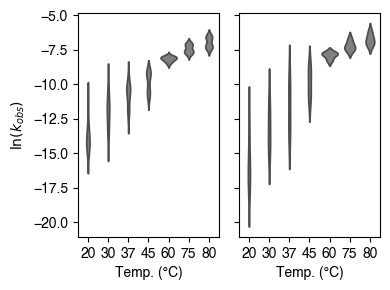

In [ ]:
sites_dict_hiv = {'A': [2, 3, 20, 22, 27, 35, 61, 62], 'C': [19, 24, 29, 30, 37, 39, 41, 44, 45]}
temps = [20, 30, 37, 45, 60, 75, 80]
hiv_a_kobs = process_select_lnkobs(fits, temps, sites_dict['A'], '4U_', 'A')
hiv_c_kobs = process_select_lnkobs(fits, temps, sites_dict['C'], '4U_', 'C')

hiv_ac_kobs = pd.concat([hiv_a_kobs, hiv_c_kobs])
hiv_ac_kobs.reset_index(inplace = True)

fig, axs = plt.subplots(1, 2, figsize=(4, 3), sharey=True)
sns.violinplot(x='temperature', y='log_kobs', data=hiv_a_kobs, inner=None, hue='base', palette='gray', dodge='auto', ax = axs[0])
sns.violinplot(x='temperature', y='log_kobs', data=hiv_c_kobs, inner=None, hue='base', palette='gray', dodge='auto', ax = axs[1])
axs[0].set_xlabel('Temp. (°C)')
axs[0].set_ylabel(r'$\ln(k_{obs})$')
axs[1].set_xlabel('Temp. (°C)')

axs[0].tick_params(axis='x')
axs[0].legend_.remove()
axs[1].legend_.remove()

plt.tight_layout()
plt.savefig(f'fourU_avg_kobs_violin_ACs.pdf')

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_18518/2556096334.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  select_fits_A = select_fits_A[~((select_fits['site'] == 35) & (select_fits['disp_name'] == 'hiv_a35g'))]
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_18518/2556096334.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  select_fits_A = select_fits_A[~((select_fits['site'] == 30) & (select_fits['disp_name'] == 'hiv_c30u'))]
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_18518/2556096334.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  select_fits_A = select_fits_A[~((select_fits['site'] == 35) & (select_fits['disp_name'] == 'hiv_a35g'))]
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_18518/2556096334.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  select_fits_A = select_fits_A[~((select_f

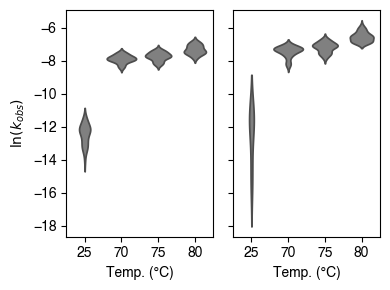

In [ ]:
sites_dict_hiv = {'A': [2, 3, 20, 22, 27, 35, 61, 62], 'C': [19, 24, 29, 30, 37, 39, 41, 44, 45]}
temps = [25, 70, 75, 80]
hiv_a_kobs = process_select_lnkobs(fits, temps, sites_dict_hiv['A'], 'hiv_', 'A')
hiv_c_kobs = process_select_lnkobs(fits, temps, sites_dict_hiv['C'], 'hiv_', 'C')

fig, axs = plt.subplots(1, 2, figsize=(4, 3), sharey=True)
sns.violinplot(x='temperature', y='log_kobs', data=hiv_a_kobs, inner=None, hue='base', palette='gray', dodge='auto', ax = axs[0])
sns.violinplot(x='temperature', y='log_kobs', data=hiv_c_kobs, inner=None, hue='base', palette='gray', dodge='auto', ax = axs[1])
axs[0].set_xlabel('Temp. (°C)')
axs[0].set_ylabel(r'$\ln(k_{obs})$')
axs[1].set_xlabel('Temp. (°C)')

axs[0].tick_params(axis='x')
axs[0].legend_.remove()
axs[1].legend_.remove()

plt.tight_layout()
plt.savefig(f'HIV_avg_kobs_violin_ACs.pdf')

### 4U_filt (from P4P6 run, pH 8)

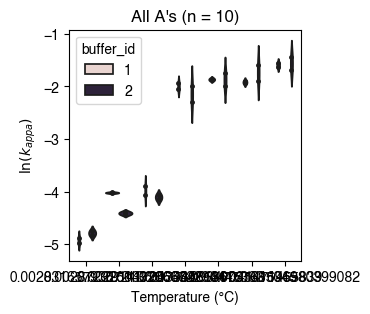

In [ ]:
all_melted = fits.copy()#[fits['temperature'] > 59]
# filt name contains "4U_wt" or "4U_a8c"
all_melted = all_melted[all_melted['disp_name'].str.contains('pH8_')]
# filter temps 25, 30, 37, 45, 52, 60, 75
#all_melted = all_melted[all_melted['temperature'] > 24]
all_melted.loc[:, 'inv_temp'] = 1/(273.15 + all_melted['temperature'])
all_melted.loc[:, 'log_kobs'] = all_melted['log_kappa'] + all_melted['log_kdeg']
# exclude filter out values under -10
#all_melted = all_melted[all_melted['log_kobs'] > -9.5]

a_sites = np.array([1])
a_sites_a = a_sites + 121
a_sites_b = a_sites + 184
all_a_sites = np.concatenate([a_sites_a, a_sites_b])
all_melted_C = all_melted[all_melted['site'].isin(all_a_sites)]

# get average at each 'inv_temp' and 'site'
avg_kobs_C = all_melted_C.groupby(['inv_temp', 'temperature', 'site', 'disp_name', 'buffer_id'])['log_kappa'].mean().reset_index()

fig, ax = plt.subplots(figsize=(3, 3))
sns.violinplot(x='inv_temp', y='log_kappa', data=avg_kobs_C, inner = 'points', hue = 'buffer_id', ax = ax)
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel(r'$\ln(k_{appa})$')
ax.set_title('All A\'s (n = 10)')
# move legend outside of plot
#plt.savefig('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/avg_kobs_violin_As.pdf')
plt.show()

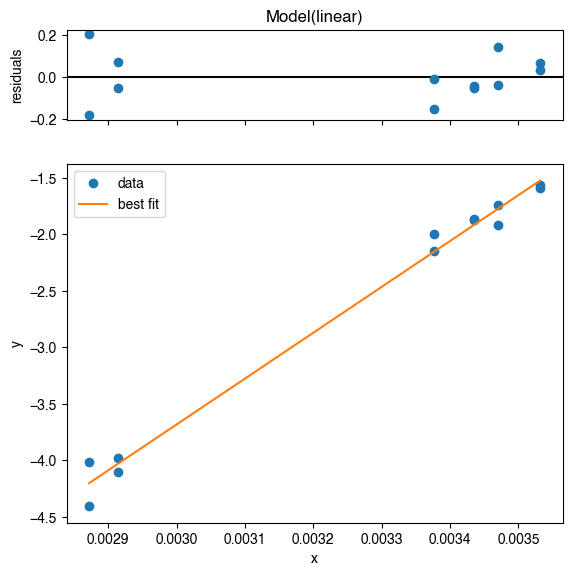

np.float64(5.6650942900321715)

In [ ]:
# filter under 80
all_melted_C = all_melted_C[all_melted_C['temperature'] < 80]
# Compute mean and standard deviation of log_kobs at each inv_temp for weighting
grouped = all_melted_C.groupby(['inv_temp', 'buffer_id'])['log_kappa'].agg(['mean', 'std']).reset_index()
grouped['weight'] = 1 / (grouped['std'] ** 2)  # Inverse variance weighting

# weighted linear fit
model = LinearModel()
params = model.make_params()
result = model.fit(grouped['mean'], params, x=grouped['inv_temp'])
result.plot()
plt.show()

pH8_lnkappa = result.eval(x = 1 / (273.15 + 23))
pH8_lnkappa_err = result.eval_uncertainty(x = 1 / (273.15 + 23))

# kdeg at 23C
pH8_lnkdeg = -7.81875375
pH8_lnkdeg_err = 0.13213564787475215

# calc lnkobs = ln(kadd/kdeg) = ln(kadd) + ln(kdeg)
pH8_lnkobs = pH8_lnkappa - pH8_lnkdeg
pH8_lnkobs

## CANNOT USE THIS FOR P4P6

### Aggregated Linear fits of $k_{obs}$

In [ ]:
sites_dict_hiv = {'C': [19, 24, 29, 30, 37, 39, 41, 44, 45], 'A': [2, 3, 20, 22, 27, 35, 61, 62], 
                  'G': [17, 18, 21, 26, 28, 32, 33, 34, 36, 43]}
                  

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


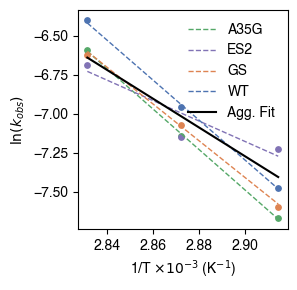

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


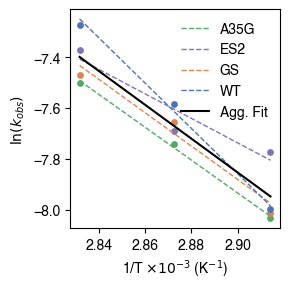

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


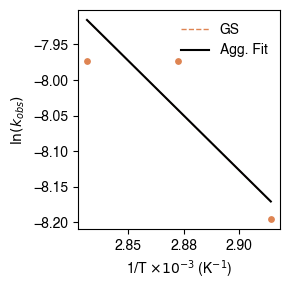

In [ ]:

# exclude disp_name == 'hiv_c30u'
fits = fits[~(fits['disp_name'] == 'hiv_c30u')]
Csites_hiv_df = aggregated_linfit_melted(fits, sites_dict_hiv['C'], 'hiv_', 'C', plot = True)
Asites_hiv_df = aggregated_linfit_melted(fits, sites_dict_hiv['A'], 'hiv_', 'A', plot = True)
Gsites_hiv_df = aggregated_linfit_melted(fits, sites_dict_hiv['G'], 'hiv_', 'G', plot = True)

ACsites_hiv_df = pd.concat([Asites_hiv_df, Csites_hiv_df])
ACsites_hiv_df.reset_index(inplace = True)
ACsites_hiv_df['lnkadd_20C'] = ACsites_hiv_df.apply(lambda x: eval_extrapolate(1/(273.15 + 20), x['slope'], x['slope_se'], x['intercept'], x['intercept_se'])[0], axis=1)
ACsites_hiv_df['lnkadd_20C_err'] = ACsites_hiv_df.apply(lambda x: eval_extrapolate(1/(273.15 + 20), x['slope'], x['slope_se'], x['intercept'], x['intercept_se'])[1], axis=1)
ACsites_hiv_df.to_csv('hiv_agg_kaddfits.csv', index = False)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


lnkadd_val: -13.619173991822084, lnkadd_err: 0.3825003898463261
lnkadd_val: -11.609495458515378, lnkadd_err: 0.3119437685301567
lnkadd_val: -9.788030736609006, lnkadd_err: 5.1907219003000575


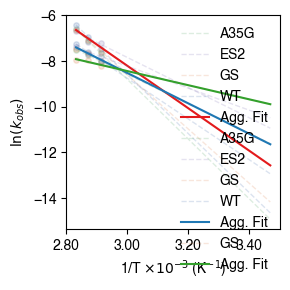

In [ ]:
# exclude disp_name == 'hiv_c30u'
fits = fits[~(fits['disp_name'] == 'hiv_c30u')]

fig, ax = plt.subplots(figsize=(3, 3))

ax = aggregated_linfit_melted_ax(fits, sites_dict_hiv['C'], 'hiv_', 'C', ax, plot = True, extrapolate = 15)
ax = aggregated_linfit_melted_ax(fits, sites_dict_hiv['A'], 'hiv_', 'A', ax, plot = True, extrapolate = 15)
ax = aggregated_linfit_melted_ax(fits, sites_dict_hiv['G'], 'hiv_', 'G', ax, plot = True, extrapolate = 15)

# formatter
formatter = FuncFormatter(thousands)
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel(r'$\ln(k_{obs})$')
ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
plt.legend(frameon=False, loc='upper right')
plt.tight_layout()
#plt.title("Weighted Linear Fit at Melted Temps.")
#plt.savefig()
plt.savefig(f'agg_fit_hiv_melt_ACGs_15.pdf')
plt.show()

### Using `lmfit` to perform weighted fits

In [ ]:
def aggregated_lmfit_melted(fits, sites, disp_name, fit_param = 'log_kobsT'):
    # 'log_kobsT' for eyring or 'log_kobs' for arrhenius
    
    all_melted = fits.copy()#[fits['temperature'] > 59]
    # filt name contains "4U_wt" or "4U_a8c"
    all_melted = all_melted[all_melted['disp_name'].str.contains(disp_name)]
    all_melted = all_melted[all_melted['temperature'] > 59]

    all_melted.loc[:, 'inv_temp'] = 1/(273.15 + all_melted['temperature'])
    all_melted.loc[:, 'log_kobs'] = all_melted['log_kappa'] + all_melted['log_kdeg']
    all_melted.loc[:, 'log_kobsT'] = all_melted['log_kobs'] + np.log(all_melted['inv_temp'])

    if disp_name == 'hiv_':
        all_melted = all_melted[all_melted['log_kobs'] > -9.5]

    # filter sites 7, 8, 9, 15, 16, 18, 22, 25, 26, 29, 34, 35
    select_melted = all_melted[all_melted['site'].isin(sites)]

    # exclude site 35 and disp_name == 'hiv_a35g'
    select_melted = select_melted[~((select_melted['site'] == 35) & (select_melted['disp_name'] == 'hiv_a35g'))]

    # exclude site 30 disp_name == 'hiv_c30u'
    select_melted = select_melted[~((select_melted['site'] == 30) & (select_melted['disp_name'] == 'hiv_c30u'))]

    # Compute mean and standard deviation of log_kobs at each inv_temp for weighting
    grouped = select_melted.groupby(['inv_temp'])[fit_param].agg(['mean', 'std']).reset_index()
    grouped['weight'] = 1 / (grouped['std'] ** 2)  # Inverse variance weighting

    # weighted linear fit
    model = LinearModel()
    params = model.make_params()
    result = model.fit(grouped['mean'], params, x=grouped['inv_temp'], weights=grouped['weight'])
    return result

In [ ]:
eyring_aggfits = {}
for construct in ['4U_', 'hiv_']:
    for base in ['A', 'C']:
        dict_key = f'{construct}{base}'
        eyring_aggfits[dict_key] = aggregated_lmfit_melted(fits, sites_dict[base], construct, 'log_kobsT')

In [ ]:
arrhenius_aggfits = {}
for construct in ['4U_', 'hiv_']:
    for base in ['A', 'C']:
        dict_key = f'{construct}{base}'

        if construct == 'hiv_':
            arrhenius_aggfits[dict_key] = aggregated_lmfit_melted(fits, sites_dict_hiv[base], construct, 'log_kobs')
        elif construct == '4U_':
            # filter out 4U_wt and 4U_a8c
            arrhenius_aggfits[dict_key] = aggregated_lmfit_melted(fits, sites_dict[base], construct, 'log_kobs')

In [ ]:
# also do for each disp_name

for construct in ['4U_wt', '4U_a8c', 'hiv_a35g', 'hiv_wt', 'hiv_gs', 'hiv_es2']:
    for base in ['A', 'C']:
        dict_key = f'{construct}{base}'

        if 'hiv_' in construct:
            arrhenius_aggfits[dict_key] = aggregated_lmfit_melted(fits, sites_dict_hiv[base], construct, 'log_kobs')
        elif '4U_' in construct:
            # filter out 4U_wt and 4U_a8c
            arrhenius_aggfits[dict_key] = aggregated_lmfit_melted(fits, sites_dict[base], construct, 'log_kobs')

In [ ]:
# Load NTP data

all_fit_params = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/05_nmr_ntp_adduction/01.047.NMR_NTP_adduction_kinetics/data/peak_analysis/all_data_fitparams.csv'
nmr_ntp = pd.read_csv(all_fit_params)
peak8 = nmr_ntp[nmr_ntp['peak'] == 'peak8']
peak8['lnkaddT'] = peak8['lnkadd'] + np.log(peak8['1/T'])

for ntp in ['ATP', 'CTP']:
    peak8_ntp = peak8[peak8['ntp'] == ntp]
    dict_key = f'nmr_{ntp[0]}'

    # eyring
    model = LinearModel()
    params = model.make_params()
    result = model.fit(peak8_ntp['lnkaddT'], params, x=peak8_ntp['1/T'])
    eyring_aggfits[dict_key] = result

    # arrhenius
    model = LinearModel()
    params = model.make_params()
    result = model.fit(peak8_ntp['lnkadd'], params, x=peak8_ntp['1/T'])
    arrhenius_aggfits[dict_key] = result

In [ ]:
store_results = []

for construct in ['4U_', 'hiv_', 'nmr_', '4U_wt', '4U_a8c', 'hiv_a35g', 'hiv_wt', 'hiv_gs', 'hiv_es2']:
    for base in ['A', 'C']:
        fit_result = arrhenius_aggfits[f'{construct}{base}']
        
        # calc lnkadd at 20C
        lnkadd_20C = fit_result.eval(x = 1/(273.15 + 20))
        lnkadd_20C_err = fit_result.eval_uncertainty(x = 1/(273.15 + 20))

        lnkadd_25C = fit_result.eval(x = 1/(273.15 + 25))
        lnkadd_25C_err = fit_result.eval_uncertainty(x = 1/(273.15 + 25))

        store_results.append([f'{construct}{base}', lnkadd_20C, lnkadd_20C_err, -fit_result.params['slope'].value/1000., fit_result.params['intercept'].value, fit_result.params['slope'].stderr/1000., fit_result.params['intercept'].stderr,
                              lnkadd_25C, lnkadd_25C_err])
    
calc_kadd_df = pd.DataFrame(store_results, columns = ['construct', 'lnkadd_20C', 'lnkadd_20C_err', 'slope', 'intercept', 'slope_err', 'intercept_err', 'lnkadd_25C', 'lnkadd_25C_err'])
calc_kadd_df['group'] = calc_kadd_df['construct'].str[-1]
calc_kadd_df['construct'] = calc_kadd_df['construct'].str[:-1]
calc_kadd_df

In [ ]:
# melted fits
melted = fits[fits['temperature'] > 59]
melted['inv_temp'] = 1/(273.15 + melted['temperature'])
melted['log_kobs'] = melted['log_kappa'] + melted['log_kdeg']
melted['site_var'] = melted['site'].astype(str) + '_' + melted['disp_name']

melted_4U_A = melted[melted['disp_name'].str.contains('4U_') & melted['site'].isin(sites_dict['A'])]
melted_4U_C = melted[melted['disp_name'].str.contains('4U_') & melted['site'].isin(sites_dict['C'])]
melted_hiv_A = melted[melted['disp_name'].str.contains('hiv_') & melted['site'].isin(sites_dict_hiv['A'])]
melted_hiv_C = melted[melted['disp_name'].str.contains('hiv_') & melted['site'].isin(sites_dict_hiv['C'])]
melted_4U_G = melted[melted['disp_name'].str.contains('4U_') & melted['site'].isin(sites_dict['G'])]
melted_hiv_G = melted[melted['disp_name'].str.contains('hiv_') & melted['site'].isin(sites_dict_hiv['G'])]

melted_all_A = pd.concat([melted_4U_A, melted_hiv_A])
melted_all_C = pd.concat([melted_4U_C, melted_hiv_C])
melted_all_G = pd.concat([melted_4U_G, melted_hiv_G])

In [ ]:
from statsmodels.stats.anova import anova_lm

In [ ]:
model_reduced = smf.ols('log_kobs ~ inv_temp', data = melted_all_A).fit()
model_full = smf.ols('log_kobs ~ inv_temp * site', data = melted_all_A).fit()

anova_results = anova_lm(model_reduced, model_full)
print(anova_results)

In [ ]:
model_reduced = smf.ols('log_kobs ~ inv_temp', data=melted_4U_A).fit()
model_full = smf.ols('log_kobs ~ inv_temp * site', data=melted_4U_A).fit()

anova_results = anova_lm(model_reduced, model_full)
print(anova_results)

In [ ]:
model_reduced = smf.ols('log_kobs ~ inv_temp', data=melted_4U_C).fit()
model_full = smf.ols('log_kobs ~ inv_temp * site', data=melted_4U_C).fit()

anova_results = anova_lm(model_reduced, model_full)
print(anova_results)

In [ ]:
arrhenius_aggfits['nmr_A'].params

In [ ]:
arrhenius_aggfits['4U_a8cA'].params

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
arrhenius_aggfits['nmr_A'].plot_fit(ax = ax)
arrhenius_aggfits['hiv_A'].plot_fit(ax = ax)
#arrhenius_aggfits['4U_a8cA'].plot_fit(ax = ax)
#arrhenius_aggfits['4U_wtA'].plot_fit(ax = ax)
plt.show()

In [ ]:
def plot_grouped_barplot(results_df, func='dH', label = None):
    """
    Grouped barplot (by group and construct) of a thermodynamic parameter with error bars.
    
    Parameters:
    - results_df: DataFrame with columns ['group', 'construct', func, f"{func}_err"]
    - func: str, one of 'dH', 'dS', or 'dG20' or 'lnkadd_20C'
    """
    err_col = f"{func}_err"
    
    groups = results_df['group'].unique()
    constructs = results_df['construct'].unique()
    n_groups = len(groups)
    n_constructs = len(constructs)

    bar_width = 0.8 / n_constructs
    x = np.arange(n_groups)  # base x positions for groups

    fig, ax = plt.subplots(figsize=(2, 3))

    color_dict = {'4U_wt': 'darkgray', '4U_a8c': 'darkred',
                    'hiv_a35g': '#55a868', 'hiv_c30u': '#c54f53', 'hiv_wt': '#4d73b1', 'hiv_gs': '#de8452', 'hiv_es2': '#8173b5',
                    '4U_': 'darkgray', 'hiv_': '#20a39e', 'nmr_': 'orange'}

    for i, construct in enumerate(constructs):
        offset = (i - n_constructs / 2 + 0.5) * bar_width
        values = []
        errors = []
        for group in groups:
            subset = results_df[(results_df['group'] == group) & (results_df['construct'] == construct)]
            if not subset.empty:
                values.append(subset[func].values[0])
                errors.append(subset[err_col].values[0])
            else:
                values.append(np.nan)
                errors.append(0)

        ax.bar(x + offset, values, width=bar_width, label=construct, yerr=errors, capsize=2, edgecolor='white', 
               color=color_dict[construct], alpha=1, error_kw=dict(ecolor='black', lw=1))

    if func == 'dH':
        ylabel = r'$\Delta H^\ddagger$ (kcal/mol)'
    elif func == 'dS':
        ylabel = r'$\Delta S^\ddagger$ (kcal/mol/K)'
    elif func == 'dG20':
        ylabel = r'$\Delta G^\ddagger_{20°C}$ (kcal/mol)'
    elif func == 'lnkadd_20C':
        ylabel = r'$\ln(k_{add, 20°C})$'
    elif func == 'slope':
        ylabel = r'$E_a$ (kcal/mol)'
    elif func == 'intercept':
        ylabel = r'Pre-exponential $\ln(A)$'

    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.set_ylabel(ylabel)
    ax.legend(title='', fontsize=8)
    plt.tight_layout()
    plt.savefig(f'{func}_grouped_barplot_{label}.pdf')
    plt.show()

In [ ]:
calc_kadd_df.to_csv('newcalc_kadd_arrhenius.csv', index = False)

In [ ]:
calc_kadd_df = pd.read_csv('newcalc_kadd_arrhenius.csv')
#calc_kadd_df['group'] = calc_kadd_df['construct'].str.split('_').str[0] + calc_kadd_df['group']
calc_kadd_df

In [ ]:
fourU_to_plot = calc_kadd_df[calc_kadd_df['construct'] == '4U_']
hiv_to_plot = calc_kadd_df[calc_kadd_df['construct'] == 'hiv_']
nmr_to_plot = calc_kadd_df[calc_kadd_df['construct'].str.contains('nmr_')]

all_to_plot = pd.concat([fourU_to_plot, hiv_to_plot, nmr_to_plot])

plot_grouped_barplot(all_to_plot, func='lnkadd_20C')

In [ ]:
fourU_to_plot = calc_kadd_df[calc_kadd_df['construct'] == '4U_']
nmr_to_plot = calc_kadd_df[calc_kadd_df['construct'].str.contains('nmr_')]

fourU_to_plot = pd.concat([fourU_to_plot, nmr_to_plot])

plot_grouped_barplot(fourU_to_plot, func='lnkadd_20C', label = '4U_agg')
plot_grouped_barplot(fourU_to_plot, func='slope', label = '4U_agg')
plot_grouped_barplot(fourU_to_plot, func='intercept', label = '4U_agg')

In [ ]:
fourU_to_plot = calc_kadd_df[calc_kadd_df['construct'] == 'hiv_']
nmr_to_plot = calc_kadd_df[calc_kadd_df['construct'].str.contains('nmr_')]

fourU_to_plot = pd.concat([fourU_to_plot, nmr_to_plot])

plot_grouped_barplot(fourU_to_plot, func='lnkadd_20C', label = 'hiv_all')
plot_grouped_barplot(fourU_to_plot, func='slope', label = 'hiv_all')
plot_grouped_barplot(fourU_to_plot, func='intercept', label = 'hiv_all')